In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

In [2]:
def read_datasets():
    real_users = pd.read_csv("../cresci-2015/E13/users.csv")
    fake_users = pd.read_csv("../cresci-2015/INT/users.csv")
    x = pd.concat([real_users,fake_users])    
    y = len(fake_users)*[0] + len(real_users)*[1]
    return x,y

In [3]:
def predict_sex(name):
    d = gender.Detector(case_sensitive=False)
    first_name= str(name).split(' ')[0]
    sex = d.get_gender(u"{}".format(first_name))
    sex_code_dict = {'female': -2, 'mostly_female': -1,'unknown':0, 'andy': 0, 'mostly_male':1, 'male': 2}
    code = sex_code_dict[sex]
    return code

In [4]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code'] = predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x = x.loc[:,feature_columns_to_use]
    return x

In [5]:
def plot_confusion_matrix(cm, title='CONFUSION MATRIX', cmap=plt.cm.Reds):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def train_with_xgboost(X_train, y_train, X_test):
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)
    classifier = XGBClassifier(n_estimators=100, learning_rate=0.2, max_depth=3)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    return y_pred

In [7]:
x, y = read_datasets()
x = extract_features(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=44)
y_pred_xgboost = train_with_xgboost(X_train, y_train, X_test)

[[384   4]
 [ 52 406]]
              precision    recall  f1-score   support

        Fake       0.88      0.99      0.93       388
     Genuine       0.99      0.89      0.94       458

    accuracy                           0.93       846
   macro avg       0.94      0.94      0.93       846
weighted avg       0.94      0.93      0.93       846

accuracy: 0.933806146572104


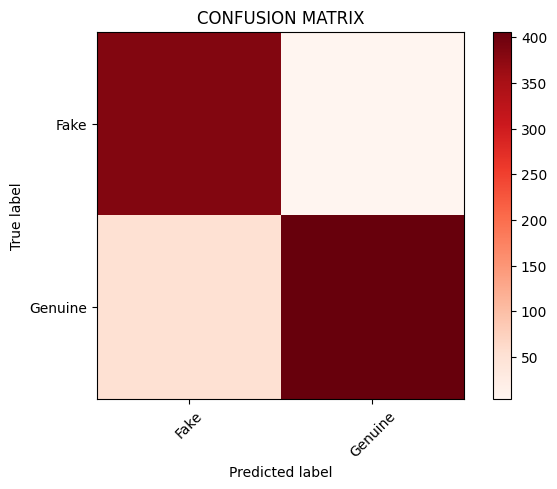

In [8]:
confusionMatrixXGBoost = confusion_matrix(y_test, y_pred_xgboost)
print(confusionMatrixXGBoost)
print(classification_report(y_test, y_pred_xgboost, target_names=['Fake', 'Genuine']))
print('accuracy:', accuracy_score(y_test, y_pred_xgboost))
plot_confusion_matrix(confusionMatrixXGBoost)